<a href="https://colab.research.google.com/github/antonioGoncalves64/pyspark/blob/main/TutorialPyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

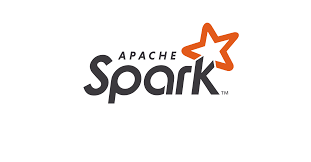

# Install pyspark

The easy way of installing PySpark on Google Colab is to use pip install.

In [1]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 52 kB/s 
     |████████████████████████████████| 199 kB 49.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=c958de17a49c2a65bfa5a0386d4cd37cd4611499b1c869450e45426990f81079
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Creating a SparkSession
After installation, we can create a Spark context and check its information.

In [34]:
from pyspark import SparkConf 
from pyspark.context import SparkContext 

import findspark

findspark.init()

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]").setAppName("Intro pyspark"))

spark = SparkSession.builder.master("local[1]").appName('SparkDataFrame').getOrCreate()




spark


# Resilient Distributed Datasets (RDD)
Spark revolves around the concept of a resilient distributed dataset (RDD), which is a fault-tolerant collection of elements that can be operated on in parallel.

## How to create RDDs

There are two ways to create RDDs:

* parallelizing an existing collection in your driver program, or
* referencing a dataset in an external storage system, such as a shared filesystem, HDFS, HBase, or any data source offering a Hadoop InputFormat.

### Parallelized collection

Parallelized collections are created by calling SparkContext’s parallelize method on an existing iterable or collection in your driver program. The elements of the collection are copied to form a distributed dataset that can be operated on in parallel. For example, here is how to create two parallelized collection: one for holding the numbers 1 to 5 and the other for hoding a String.

In [3]:
numRDD = sc.parallelize([1,2,3,4,5])
print ("numRDD:   ", type(numRDD)) #confirm type of object RDD

helloRDD = sc.parallelize(("Hello world"))
print ("helloRDD: ",type(helloRDD)) #confirm type of object RDD

numRDD:    <class 'pyspark.rdd.RDD'>
helloRDD:  <class 'pyspark.rdd.RDD'>


Once created, the distributed dataset (distData) can be operated on in parallel. For example, we can call distData.reduce(lambda a, b: a + b) to add up the elements of the list.

In [4]:
distData = sc.parallelize([1,2,3])
distData.reduce(lambda a, b: a + b)

6

One important parameter for parallel collections is the number of partitions to cut the dataset into. Spark will run one task for each partition of the cluster. Typically you want 2-4 partitions for each CPU in your cluster. Normally, Spark tries to set the number of partitions automatically based on your cluster. However, you can also set it manually by passing it as a second parameter to parallelize (e.g. sc.parallelize(data, 10))

In [5]:
data01 = sc.parallelize([1,2,3,4,5])
print ("Data01 NumPartitions: ", data01.getNumPartitions())

data02 = sc.parallelize([1,2,3,4,5],3)
print ("data02 NumPartitions: ", data02.getNumPartitions())

Data01 NumPartitions:  2
data02 NumPartitions:  3


### External Datasets
PySpark can create distributed datasets from any storage source supported by Hadoop, including your local file system, HDFS, Cassandra, HBase, Amazon S3, etc. Spark supports text files, SequenceFiles, and any other Hadoop InputFormat.

Text file RDDs can be created using SparkContext’s textFile method. This method takes a URI for the file (either a local path on the machine, or a hdfs://, s3a://, etc URI) and reads it as a collection of lines. Here is an example invocation:

In [6]:

!curl https://perso.telecom-paristech.fr/eagan/class/igr204/data/cars.csv >> cars.csv


fileRDD = sc.textFile("cars.csv")

newRDD= fileRDD.take(3)

for i in newRDD:
    print(i)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22663  100 22663    0     0  37834      0 --:--:-- --:--:-- --:--:-- 37771
Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin
STRING;DOUBLE;INT;DOUBLE;DOUBLE;DOUBLE;DOUBLE;INT;CAT
Chevrolet Chevelle Malibu;18.0;8;307.0;130.0;3504.;12.0;70;US


### RDD Operations

RDDs support two types of operations: transformations and actions
 
* Transformations  create a new dataset from an existing one.
* Actions, which return a value to the driver program after running a computation on the dataset. 

For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

All transformations in Spark are lazy, in that they do not compute their results right away. Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program. This design enables Spark to run more efficiently. For example, we can realize that a dataset created through map will be used in a reduce and return only the result of the reduce to the driver, rather than the larger mapped dataset.


#### Transformations


In [7]:
# map( ) - Return a new RDD by applying a function to each element of this RDD.

RDD = sc.parallelize([1,2,3,4,5])
RDD_map = RDD.map(lambda x : x * 2)
print ("RDD_map: ",RDD_map.collect()) # action convert to a  List

RDD_map:  [2, 4, 6, 8, 10]


In [8]:
# filter( ) returns a new RDD with only the elements that pass the condition

RDD = sc.parallelize([1,2,3,4])
RDD_filter = RDD.filter(lambda x : x >2)
print ("RDD_filter: ", RDD_filter.collect()) # action convert to a  List

RDD_filter:  [3, 4]


In [9]:
# flatMap( ) returns multiple values for each element in the original RDD

RDD = sc.parallelize(["hello word", "How are you"])
RDD_flatMap = RDD.flatMap(lambda x : x.split(" "))
print ("RDD_flatMap: ", RDD_flatMap.collect()) # action convert to a  List

RDD_flatMap:  ['hello', 'word', 'How', 'are', 'you']


In [10]:
# union( ) Return the union of this RDD and another one

rdd01 = sc.parallelize([1, 3, 5, 7])
rdd02 = sc.parallelize([2, 4, 6, 8])
rdd03 = rdd01.union(rdd02)
rdd03.collect()

[1, 3, 5, 7, 2, 4, 6, 8]

#### Actions

In [11]:
# collection ( ) Return a list that contains all of the elements in this RDD

data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd  = sc.parallelize(data)

newData = rdd.collect()
for d in newData:
    print (f"Value: {d}")

Value: 1
Value: 2
Value: 3
Value: 4
Value: 5
Value: 6
Value: 7
Value: 8
Value: 9
Value: 10
Value: 11
Value: 12


In [12]:
# take(num) – Take the first num elements of the RDD

data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd  = sc.parallelize(data)

newData = rdd.take(2)
for d in newData:
    print (f"Value: {d}")

Value: 1
Value: 2


In [13]:
# first( ) – Returns the first record of the RDD

data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd  = sc.parallelize(data)

newData = rdd.first()
print (f"Value: {newData}")

Value: 1


In [14]:
# count( ) – Returns the number of records in an RDD

data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd  = sc.parallelize(data)

num = rdd.count()
print (f"Count: {num}")

Count: 12


In [15]:
# max( ) – Returns max record

data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd  = sc.parallelize(data)

num = rdd.max()
print (f"Max: {num}")

Max: 12


In [ ]:
# reduce( ) – Reduces the records to single, we can use this to count or sum

data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd  = sc.parallelize(data)

num = rdd.reduce(lambda a,b: (a+b))
print (f"Max: {num}")

## Pair RDDs

Spark Paired RDDs are RDDs containing a key-value pair. Key-value pair (KVP) consists of a two linked data item in it. Here, the key is the identifier, whereas value is the data corresponding to the key value.

#### Creating Pair RDDs
Two common ways to create pair RDD:

* From a list of key-value tuples
* From a regular RDD

In [16]:
# Create a Pair RDD from regular RDD

rdd = sc.parallelize(["b", "a", "c"])
sorted(rdd.map(lambda x: (x, 1)).collect())

[('a', 1), ('b', 1), ('c', 1)]

In [17]:
# Create a Pair RDD from a list

rdd = sc.parallelize([(1,"a"), (2,"b"), (3,"c")])
rdd.collect()

[(1, 'a'), (2, 'b'), (3, 'c')]

#### Transformations on pair RDDs

All regular transformations work on pair RDD. Have to pass functions that operate on key value pairs rather than on individual elements

In [18]:
# reduceByKey(fun) - groups all the values with the same key

rdd = sc.parallelize([("a",1), ("b",2), ("c", 10),("a", 2), ("d", 5), ("a", 4) ])
rdd_reduceByKey = rdd.reduceByKey(lambda x, y: x+y )
rdd_reduceByKey.collect()

[('b', 2), ('c', 10), ('d', 5), ('a', 7)]

In [19]:
# sortByKey(fun) - Order RDD pair by key

rdd = sc.parallelize([("a",1), ("c",2), ("b", 10),("a", 2), ("d", 5), ("a", 4) ])
rdd_reduceByKey = rdd.reduceByKey(lambda x, y: x+y )
rdd_reduceByKey.sortByKey(ascending = True).collect()

[('a', 7), ('b', 10), ('c', 2), ('d', 5)]

In [21]:
# groupByKey( ) - Groups all the values with the same key in the pair

rdd = sc.parallelize([("a",1), ("c",2), ("b", 10),("a", 2), ("d", 5), ("a", 4) ])
rdd_groupByKey = rdd.groupByKey().collect()
for letter, value in  rdd_groupByKey:
    print (letter, list(value))

c [2]
b [10]
d [5]
a [1, 2, 4]


In [20]:
# join( ) - transformation joins the two pair RDDs based on their key

rdd01 = sc.parallelize([("a",1), ("b", 5),("c", 7) ])
rdd02 = sc.parallelize([("a",2), ("b", 3),("d", 4) ])

rdd01. join(rdd02).collect()

[('b', (5, 3)), ('a', (1, 2))]

In [35]:
# countByKey( ) - action counts the number of elements for each key

rdd = sc.parallelize([("a",2), ("b", 4),("a", 3) ])
for key, val in  rdd.countByKey().items():
    print (key, val)

a 2
b 1


In [22]:
# collectAsMap( ) - action return the key-value pairs in the RDD as a dictionary

rdd = sc.parallelize([("a",2), ("b", 4),("c", 3) ])
rdd.collectAsMap()

{'a': 2, 'b': 4, 'c': 3}

## Example compute-intensive tasks

Spark can also be used for compute-intensive tasks. 

This code estimates π by "throwing darts" at a circle. We pick random points in the unit square ((0, 0) to (1,1)) and see how many fall in the unit circle. The fraction should be π / 4, so we use this to get our estimate.

In [31]:
from random import random
NUM_SAMPLES = 10000000

def sample(p):
    x, y = random(), random()
    return 1 if x*x + y*y < 1 else 0

sample_nums = sc.parallelize(range(0, NUM_SAMPLES))
#sample = sample_nums.map(lambda a: 1 if 1<2 else 0)
sample = sample_nums.map(sample)
count = sample.reduce(lambda a, b: a + b)
val = 4.0 * count / NUM_SAMPLES

print (F"Pi is roughly {val}")

Pi is roughly 3.1423168


# DataFrame


A DataFrame is a two-dimensional labeled data structure with columns of potentially different types. You can think of a DataFrame like a spreadsheet, a SQL table, or a dictionary of series objects. Apache Spark DataFrames provide a rich set of functions (select columns, filter, join, aggregate) that allow you to solve common data analysis problems efficiently.

Apache Spark DataFrames are an abstraction built on top of Resilient Distributed Datasets (RDDs). Spark DataFrames and Spark SQL use a unified planning and optimization engine, allowing you to get nearly identical performance across all supported languages (Python, SQL, Scala, and R)

## Create a Spark Session

In [32]:
# create a Spark Session
import pyspark
from pyspark.sql import SparkSession

# create a spark session
spark = SparkSession.builder.master("local[1]").appName('SparkDataFrame').getOrCreate()

spark 



##  Create a DataFrame 

###  Create a DataFrame from RDD

Most Apache Spark queries return a DataFrame. This includes reading from a table, loading data from files, and operations that transform data.

In [ ]:
iphones_RDD = sc.parallelize([ ("XS", 2018, 5.65, 2.79, 6.24), \
("XR", 2018, 5.94, 2.98, 6.84),\
("X10", 2017, 5.65, 2.79, 6.13),\
("8Plus", 2017, 6.23, 3.07, 7.12)\
])

names = ['Model', 'Year', 'Height', 'Width', 'Weight']

iphones_df = spark.createDataFrame(iphones_RDD, schema=names)
iphones_df.show()



+-----+----+------+-----+------+
|Model|Year|Height|Width|Weight|
+-----+----+------+-----+------+
|   XS|2018|  5.65| 2.79|  6.24|
|   XR|2018|  5.94| 2.98|  6.84|
|  X10|2017|  5.65| 2.79|  6.13|
|8Plus|2017|  6.23| 3.07|  7.12|
+-----+----+------+-----+------+



###  Create a DataFrame from pandas

ou can also create a Spark DataFrame from a list or a pandas DataFrame, such as in the following example


In [ ]:
import pandas as pd

data = [[1, "Elia"], [2, "Teo"], [3, "Fang"]]

pdf = pd.DataFrame(data, columns=["i", "n"])

df1 = spark.createDataFrame(pdf)
df1.show()

df2 = spark.createDataFrame(data, schema="id LONG, name STRING")
df2.show()

+---+----+
|  i|   n|
+---+----+
|  1|Elia|
|  2| Teo|
|  3|Fang|
+---+----+

+---+----+
| id|name|
+---+----+
|  1|Elia|
|  2| Teo|
|  3|Fang|
+---+----+



### Load data into a DataFrame from files

You can load data from many supported file formats. The following example uses a dataset available in the datasets directory.

In [37]:
!curl https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties-2021.csv >> us-counties-2021.csv


df_csv = spark.read.csv("us-counties-2021.csv", sep=',', header=True, inferSchema=True)

df_csv.tail(3)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.9M  100 47.9M    0     0   251M      0 --:--:-- --:--:-- --:--:--  251M


[Row(date=datetime.datetime(2021, 12, 31, 0, 0), county='Uinta', state='Wyoming', fips=56041, cases=4154, deaths=31),
 Row(date=datetime.datetime(2021, 12, 31, 0, 0), county='Washakie', state='Wyoming', fips=56043, cases=1879, deaths=37),
 Row(date=datetime.datetime(2021, 12, 31, 0, 0), county='Weston', state='Wyoming', fips=56045, cases=1254, deaths=14)]

## DataFrame Operations

Like RDD Spark suporte  support two types of Data Frame operations: transformations and actions
 
* Transformations  create a new dataset from an existing one.
* Actions, which return a value to the driver program after running a computation on the dataset. 

For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

All transformations in Spark are lazy, in that they do not compute their results right away. Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program. This design enables Spark to run more efficiently. For example, we can realize that a dataset created through map will be used in a reduce and return only the result of the reduce to the driver, rather than the larger mapped dataset.

By default, each transformed RDD may be recomputed each time you run an action on it. However, you may also persist an RDD in memory using the persist (or cache) method, in which case Spark will keep the elements around on the cluster for much faster access the next time you query it. There is also support for persisting RDDs on disk, or replicated across multiple nodes.

### Transformations

In [ ]:
# select( ) - Transformation subsets the columns in the DataFrame



covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)

county_value_df = covidDF.select("county")

county_value_df.show(10)

+--------+
|  county|
+--------+
| Autauga|
| Baldwin|
| Barbour|
|    Bibb|
|  Blount|
| Bullock|
|  Butler|
| Calhoun|
|Chambers|
|Cherokee|
+--------+
only showing top 10 rows



In [ ]:
# filter( ) transformation filters out the rows based on a condition


covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)

new_df_covidDF = covidDF.filter(covidDF.county ==  "Bibb")

new_df_covidDF.show(5)

+-------------------+------+-------+-----+-----+------+
|               date|county|  state| fips|cases|deaths|
+-------------------+------+-------+-----+-----+------+
|2021-01-01 00:00:00|  Bibb|Alabama| 1007| 1854|    46|
|2021-01-01 00:00:00|  Bibb|Georgia|13021|10273|   261|
|2021-01-02 00:00:00|  Bibb|Alabama| 1007| 1863|    46|
|2021-01-02 00:00:00|  Bibb|Georgia|13021|10433|   261|
|2021-01-03 00:00:00|  Bibb|Alabama| 1007| 1882|    46|
+-------------------+------+-------+-----+-----+------+
only showing top 5 rows



In [ ]:
# groupby() can be used to group a variable

covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)

new_df_groupByDeaths = covidDF.groupby('deaths')
new_df_groupByDeaths.count().show()

+------+-----+
|deaths|count|
+------+-----+
|   463|  258|
|   148| 1200|
|   833|   95|
|   496|  149|
|  1342|   26|
|  1088|   32|
|  3794|    7|
|  1645|   17|
|  2866|    9|
|   471|  180|
|  1829|   16|
|  1238|   22|
|  3997|    1|
|  2142|   10|
|  1591|   16|
|  3749|    6|
|  1959|   14|
|  1580|    7|
|  2366|   11|
|  3918|    1|
+------+-----+
only showing top 20 rows



In [ ]:
# orderBy() operation sorts the DataFrame based on one or more columns

covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)

new_df_groupByDate = covidDF.groupby('date')
new_df_groupByDate.count().orderBy('date').show()

+-------------------+-----+
|               date|count|
+-------------------+-----+
|2021-01-01 00:00:00| 3245|
|2021-01-02 00:00:00| 3247|
|2021-01-03 00:00:00| 3246|
|2021-01-04 00:00:00| 3246|
|2021-01-05 00:00:00| 3245|
|2021-01-06 00:00:00| 3245|
|2021-01-07 00:00:00| 3246|
|2021-01-08 00:00:00| 3245|
|2021-01-09 00:00:00| 3245|
|2021-01-10 00:00:00| 3245|
|2021-01-11 00:00:00| 3245|
|2021-01-12 00:00:00| 3245|
|2021-01-13 00:00:00| 3246|
|2021-01-14 00:00:00| 3245|
|2021-01-15 00:00:00| 3245|
|2021-01-16 00:00:00| 3245|
|2021-01-17 00:00:00| 3245|
|2021-01-18 00:00:00| 3245|
|2021-01-19 00:00:00| 3247|
|2021-01-20 00:00:00| 3246|
+-------------------+-----+
only showing top 20 rows



In [ ]:
# dropDuplicates() removes the duplicate rows of a DataFrame

covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)

newDf = covidDF.select('state','cases', 'deaths').dropDuplicates()
newDf.count()

715194

In [ ]:
# withColumnRenamed() renames a column in the DataFrame

covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)

newDf = covidDF.withColumnRenamed('deaths','mortes')
newDf.show()

+-------------------+---------+-------+----+-----+------+
|               date|   county|  state|fips|cases|mortes|
+-------------------+---------+-------+----+-----+------+
|2021-01-01 00:00:00|  Autauga|Alabama|1001| 4239|    50|
|2021-01-01 00:00:00|  Baldwin|Alabama|1003|13823|   169|
|2021-01-01 00:00:00|  Barbour|Alabama|1005| 1517|    33|
|2021-01-01 00:00:00|     Bibb|Alabama|1007| 1854|    46|
|2021-01-01 00:00:00|   Blount|Alabama|1009| 4693|    63|
|2021-01-01 00:00:00|  Bullock|Alabama|1011|  888|    22|
|2021-01-01 00:00:00|   Butler|Alabama|1013| 1522|    45|
|2021-01-01 00:00:00|  Calhoun|Alabama|1015| 9584|   157|
|2021-01-01 00:00:00| Chambers|Alabama|1017| 2366|    63|
|2021-01-01 00:00:00| Cherokee|Alabama|1019| 1429|    22|
|2021-01-01 00:00:00|  Chilton|Alabama|1021| 3004|    54|
|2021-01-01 00:00:00|  Choctaw|Alabama|1023|  491|    22|
|2021-01-01 00:00:00|   Clarke|Alabama|1025| 2418|    26|
|2021-01-01 00:00:00|     Clay|Alabama|1027| 1150|    34|
|2021-01-01 00

### Actions

In [ ]:
# printSchema() method prints the types of columns in the DataFrame

covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)
covidDF.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)



In [ ]:
# columns prints the columns of a DataFrame

covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)
covidDF.columns

['date', 'county', 'state', 'fips', 'cases', 'deaths']

In [ ]:
# describe() operation compute summary statistics of numerical columns in the DataFrame

covidDF = spark.read.csv("us-counties-2021.csv", header=True, inferSchema=True)
covidDF.describe().show()

+-------+---------+-------+------------------+------------------+------------------+
|summary|   county|  state|              fips|             cases|            deaths|
+-------+---------+-------+------------------+------------------+------------------+
|  count|  1185373|1185373|           1174570|           1185373|           1156903|
|   mean|     null|   null| 31471.97141081417| 11160.30975988149|193.60917553157006|
| stddev|     null|   null|16365.330590115294|42189.206066249295| 881.2526727171902|
|    min|Abbeville|Alabama|              1001|                 0|                 0|
|    max|  Ziebach|Wyoming|             78030|           1697286|             35382|
+-------+---------+-------+------------------+------------------+------------------+

